In [4]:
pip install spacy pandas numpy jiwer scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [3]:
#Donwload the models

!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_trf



     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------- ------------------ 6.8/12.8 MB 34.9 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 31.5 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 31.5 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 17.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     --------------------------------------- 6.8/587.7 MB 42.0 MB/s eta 0:00:14
      ------------------------------------- 12.1/587.7 MB 30.2 MB/s eta 0:00:20
     - ------------------------------------ 17.8/587.7 MB 29.6 MB/s eta 0:00:20
     - ------------------------------------ 24.6/587.7 MB 30.6 MB/s eta 0:00:19
     -- ----------------------------------- 32.5/587.7 MB 32.2 MB/s eta 0:00:18
     -- --------------------------

# 1.0 Using Spacy NER by default wihout Fine_Tuning to get a  baseline


## 1.1 Using en_core_web_sm as Languaje Model 

In [22]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


def preprocess_tweet(text, model):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    #text = text.lower()
    # Remove emojis using a regex for the Unicode emoji range
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                           u"\U0001F700-\U0001F77F"  # Alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess symbols
                           "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)  # Remove emojis from text
    text = text.replace('0x8f', '')  # Remove this specific character
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional, keeping the hashtag content)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters (optional)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove stopwords and lemmatize (using SpaCy)
    doc = model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Function to extract locations (GPE) from text
def extract_locations(text,model):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    
    return ' '.join(set(locations))

In [2]:


#_______MAIN ENTRY_____

file_path = '../data/Train_1.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['text'])
# Load the SpaCy language model
model = spacy.load('en_core_web_sm')

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(lambda text:preprocess_tweet(text, model))
# Apply the location extraction to the 'text' column
data['extracted_locations'] = data['cleaned_text'].apply(lambda text: extract_locations(text, model))

# Display the tweets with extracted locations
data[['text', 'extracted_locations']].head()


,text,extracted_locations
1,"Flash floods struck a Maryland city on Sunday,...",Maryland
2,State of emergency declared for Maryland flood...,Maryland
3,Other parts of Maryland also saw significant d...,Baltimore Maryland
4,"Catastrophic Flooding Slams Ellicott City, Mar...",
5,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland


### 1.1.1 Calculating WER with en_core_web_sm

In [3]:
from jiwer import wer

# Function to calculate Word Error Rate (WER)
def calculate_wer(row):
    if not row['location'] or not row['extracted_locations']:
        return 1.0  # If either is empty, consider it a complete error
   
    # Use WER function from jiwer package
    return wer(str(row['location']), str(row['extracted_locations']))

# Apply the WER function to compare the 'location' and 'extracted_locations'
data['wer'] = data.apply(calculate_wer, axis=1)

# Display the WER for the first few rows
data[['location', 'extracted_locations', 'wer']].head()

#Get the average WER
average_wer = data['wer'].mean()
print(f"Average Word Error Rate (WER): {average_wer:.4f}")

#Get the accuracy
accuracy = 1 - average_wer  
print(f"Accuracy: {accuracy:.4f}")



Average Word Error Rate (WER): 0.6907
Accuracy: 0.3093


## 1.2 Using en_core_web_lg as Languaje Model 

In [4]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string

#_______MAIN ENTRY_____

file_path = '../data/Train_1.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['text'])
# Load the SpaCy language model
model = spacy.load('en_core_web_lg')

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(lambda text:preprocess_tweet(text, model))
# Apply the location extraction to the 'text' column
data['extracted_locations'] = data['cleaned_text'].apply(lambda text: extract_locations(text, model))

# Display the tweets with extracted locations
data[['text', 'extracted_locations']].head()


,text,extracted_locations
1,"Flash floods struck a Maryland city on Sunday,...",Maryland
2,State of emergency declared for Maryland flood...,Maryland
3,Other parts of Maryland also saw significant d...,Baltimore Maryland Dundalk
4,"Catastrophic Flooding Slams Ellicott City, Mar...",
5,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland


### 1.2.1 Calculating WER with en_core_web_lg

In [5]:
from jiwer import wer



# Apply the WER function to compare the 'location' and 'extracted_locations'
data['wer'] = data.apply(calculate_wer, axis=1)

# Display the WER for the first few rows
data[['location', 'extracted_locations', 'wer']].head()

#Get the average WER
average_wer = data['wer'].mean()
print(f"Average Word Error Rate (WER): {average_wer:.4f}")

#Get the accuracy
accuracy = 1 - average_wer  
print(f"Accuracy: {accuracy:.4f}")



Average Word Error Rate (WER): 0.7338
Accuracy: 0.2662


### 1.3 Using en_core_web_trf as Languaje Model 

In [22]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


#_______MAIN ENTRY_____

file_path = '../data/Train_1.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['text'])
# Load the SpaCy language model
model = spacy.load('en_core_web_trf')

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(lambda text:preprocess_tweet(text, model))
# Apply the location extraction to the 'text' column
data['extracted_locations'] = data['cleaned_text'].apply(lambda text: extract_locations(text, model))

# Display the tweets with extracted locations
data[['text', 'extracted_locations']].head()


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\ai4good_location_mention_recognition\.venv\Lib\site-packages\thinc\shims\pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

,text,extracted_locations
1,"Flash floods struck a Maryland city on Sunday,...",Maryland
2,State of emergency declared for Maryland flood...,Maryland
3,Other parts of Maryland also saw significant d...,Dundalk Catonsville Maryland Baltimore
4,"Catastrophic Flooding Slams Ellicott City, Mar...",Maryland Ellicott City
5,WATCH: 1 missing after flash #FLOODING devasta...,Maryland Ellicott City


### 1.3.1 Calculating WER with en_core_web_trf

In [23]:
# Apply the WER function to compare the 'location' and 'extracted_locations'
data['wer'] = data.apply(calculate_wer, axis=1)

# Display the WER for the first few rows
data[['location', 'extracted_locations', 'wer']].head()

#Get the average WER
average_wer = data['wer'].mean()
print(f"Average Word Error Rate (WER): {average_wer:.4f}")

#Get the accuracy
accuracy = 1 - average_wer  
print(f"Accuracy: {accuracy:.4f}")


Average Word Error Rate (WER): 0.6297
Accuracy: 0.3703


# 2.0- Spacy Fine Tuning For NER 


## 2.1 Functions to Split Train on Training and Validation 


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
file_path = '../data/Train_1.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['text'])
# Load the SpaCy language model
model = spacy.load('en_core_web_lg')

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(lambda text:preprocess_tweet(text, model))

# Display the tweets with extracted locations
data[['text']].head()

# Split the data (80% train, 20% validation)
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)
# Save the splits as CSV files
train_df.to_csv('../data/train.csv', index=False)
val_df.to_csv('../data/validation.csv', index=False)


## 2.2 Functions to Convert Training Dataset to Spacy Format 


In [27]:
import spacy
from spacy.tokens import DocBin,Doc

LABEL = 'GPE'

# Function to remove overlapping entities
def remove_overlapping_entities(entities):
    entities = sorted(entities, key=lambda x: x[0])  # Sort by start position
    unique_entities = []
    last_end = -1
    for start, end, label in entities:
        if start >= last_end:  # Ensure no overlap
            unique_entities.append((start, end, label))
            last_end = end
    return unique_entities

# Convert the data into SpaCy's format and add to DocBin
def convert_to_spacy_format(row):
    text = row['cleaned_text']
    locations = row['location']  # Multiple locations might be separated by spaces
    
    if pd.isna(text) or pd.isna(locations):
        return None
    
    entities = []
    for loc in locations.split(" "):  # Split locations by spaces
        loc = loc.strip()
        start = text.lower().find(loc.lower())  # Case-insensitive search
        if start != -1:
            end = start + len(loc)
            entities.append((start, end, LABEL))  # Annotate the location as GPE
    
    entities = remove_overlapping_entities(entities)
    return (text, {"entities": entities})

def create_training_data_on_spacy_format(data, model):
    # Initialize a DocBin to store the training data
    db = DocBin()
    metadata=[]
    # Process each row and create SpaCy documents with entities
    for idx, row in data.iterrows():
        spacy_format = convert_to_spacy_format(row)
        if spacy_format is not None:
            text, annotations = spacy_format
            doc = model(text)
            metadata.append({"location": row['location']})
            ents = []
            for start, end, label in annotations['entities']:
                span = doc.char_span(start, end, label=label)
                if span is not None:  # Ensure valid token boundaries
                    ents.append(span)
            doc.ents = ents  # Assign the entities to the doc
            db.add(doc)  # Add the doc to the DocBin

    # Save the DocBin to disk in .spacy format
    with open('./train_metadata.txt', 'w',encoding='utf-8') as f:
        for meta in metadata:
            f.write(f"{meta}\n")
    db.to_disk("./train.spacy")

def create_training_data_on_spacy_format(data, model, output_file):
    # Initialize a DocBin to store the training data
    db = DocBin()
    metadata = []
    
    # Process each row and create SpaCy documents with entities
    for idx, row in data.iterrows():
        spacy_format = convert_to_spacy_format(row)
        if spacy_format is not None:
            text, annotations = spacy_format
            doc = model(text)
            metadata.append({"location": row['location']})
            ents = []
            for start, end, label in annotations['entities']:
                span = doc.char_span(start, end, label=label)
                if span is not None:  # Ensure valid token boundaries
                    ents.append(span)
            doc.ents = ents  # Assign the entities to the doc
            db.add(doc)  # Add the doc to the DocBin
    # Save the DocBin to disk in .spacy format
    db.to_disk(output_file)


## 2.3 Converting Trainign Data and Hold Out Set in spcy format

In [28]:
_model = spacy.load("en_core_web_lg")
create_training_data_on_spacy_format(train_df, model, "../data/train.split.spacy")
create_training_data_on_spacy_format(val_df, model, "../data/validation.split.spacy")

### 2.4 Set Up the Fine-Tuning Pipeline in SpaCy
(***model: en_core_web_lg***)


Epoch 1 - Training Loss: 10439.28926879871 | Validation Loss: 2010.6219209315352
Validation Score: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 0.8856185690356545, 'ents_r': 1.0, 'ents_f': 0.9393401015228426, 'ents_per_type': {'GPE': {'p': 0.8856185690356545, 'r': 1.0, 'f': 0.9393401015228426}}, 'speed': 27186.141976313807}
Epoch 2 - Training Loss: 8306.53428754146 | Validation Loss: 1793.425561575593
Validation Score: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 0.8849832615973219, 'ents_r': 1.0, 'ents_f': 0.9389826208296334, 'ents_per_type': {'GPE': {'p': 0.8849832615973219, 'r': 1.0, 'f': 0.9389826208296334}}, 'speed': 21548.479572024713}
Epoch 3 - Training Loss: 7967.466737661666 | Validation Loss: 1613.317249130408
Validation Score: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 0.8905197305101059, 'ents_r': 1.0, 'ents_f': 0.9420898561792033, 'ents_per_type': {'GPE': {'p': 0.8905197305101

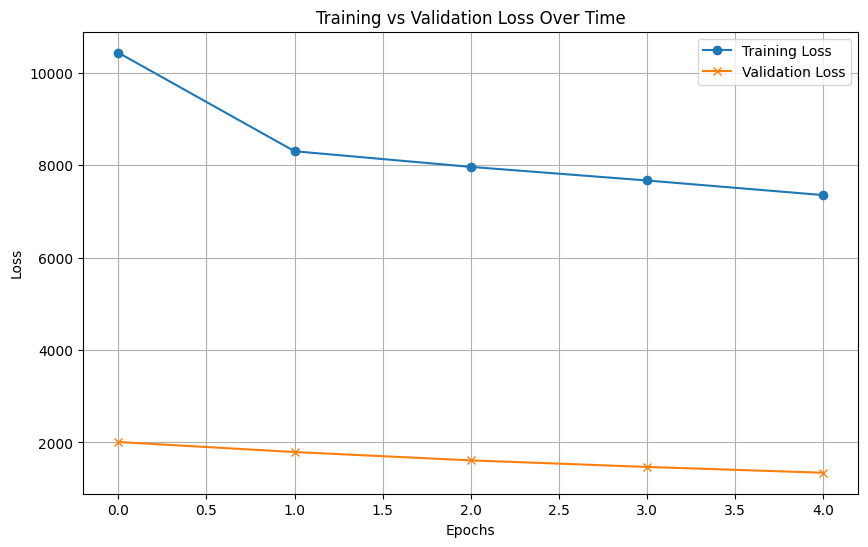

In [29]:
import spacy
from spacy.training.example import Example
from spacy.tokens import DocBin
from pathlib import Path
import random
import matplotlib.pyplot as plt



# Load the training data from .spacy file
def load_spacy_data(model,file_path):
    doc_bin = DocBin().from_disk(file_path)
    return list(doc_bin.get_docs(model.vocab))

# Function to evaluate the model on validation data
def evaluate_model(model, data):
    examples = [Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in data]
    scorer = model.evaluate(examples)
    return scorer

# Function to calculate validation loss (NLL)
def calculate_validation_loss(model, data):
    losses = {}
    for doc in data:
        example = Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]})
        # Compute loss without updating model
        model.update([example], sgd=None, losses=losses, drop=0)
    return sum(losses.values())
train_losses = []
val_losses = []

def train_model(model, train_data, valid_data):
    # Disable pipeline components that we don't want to update
    pipe_exceptions = ["ner"]  # Only train the NER component
    other_pipes = [pipe for pipe in model.pipe_names if pipe not in pipe_exceptions]
    with model.disable_pipes(*other_pipes):  # Only train NER
        optimizer = model.resume_training()
        optimizer.learn_rate = 0.00005

        # Number of training epochs
        for epoch in range(5):  # Adjust the number of epochs as needed
            losses = {}

            # Shuffle the training data for each epoch
            random.shuffle(train_data)

            # Update the model with the training data
            for doc in train_data:
                example = Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]})
                model.update([example], drop=0.15, losses=losses)

            # Get validation loss after each epoch
            val_loss = calculate_validation_loss(model, valid_data)
        
            train_loss = sum(losses.values())
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1} - Training Loss: {train_loss} | Validation Loss: {val_loss}")
            scorer = evaluate_model(model, valid_data)
            print(f"Validation Score: {scorer}")

        # Save the fine-tuned model
        model.to_disk("./fine_tuned_ner_model_lg")
        return(train_losses, val_losses)
        


#______________MAIN ENTRY_______
model = spacy.load("en_core_web_lg")
train_data = load_spacy_data(model,"../data/train.split.spacy")
valid_data = load_spacy_data(model,"../data/validation.split.spacy")
train_losses, val_losses= train_model(model, train_data, valid_data)
# Visualize the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()




### 2.5 Evaluating the fine-tuned mode on Validation Set b y calculating WER
(***model: en_core_web_lg***)


In [31]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


file_path = '../data/validation.csv'
data = pd.read_csv(file_path)

# Load the SpaCy language model
model = spacy.load('fine_tuned_ner_model_lg')

# Function to extract locations (GPE) from text
def extract_locations(text,model):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    
    return ' '.join(set(locations))

data['extracted_locations'] = data['cleaned_text'].apply(lambda text: extract_locations(text, model))
# Display the tweets with extracted locations
data[['text', 'extracted_locations']].head()


,text,extracted_locations
0,Were collecting supplies for @FriendsOfPR & @U...,
1,RT @IndiainSL: 2nd Ship from India INS Shardul...,India
2,Kerala is battling an outbreak of a bacterial ...,Kerala
3,Death toll in #ItalyEarthquake nearly doubles ...,
4,"OWH, 9/15/18 it is a scene of death & destruct...",Carolina South


In [32]:
from jiwer import wer

# Function to calculate Word Error Rate (WER)
def calculate_wer(row):
    if not row['location'] or not row['extracted_locations']:
        return 1.0  # If either is empty, consider it a complete error
   
    # Use WER function from jiwer package
    return wer(str(row['location']), str(row['extracted_locations']))

# Apply the WER function to compare the 'location' and 'extracted_locations'
data['wer'] = data.apply(calculate_wer, axis=1)

# Display the WER for the first few rows
data[['location', 'extracted_locations', 'wer']].head()

#Get the average WER
average_wer = data['wer'].mean()
print(f"Average Word Error Rate (WER): {average_wer:.4f}")

#Get the accuracy
accuracy = 1 - average_wer  
print(f"Accuracy: {accuracy:.4f}")



Average Word Error Rate (WER): 0.5244
Accuracy: 0.4756


### 2.6  Creating Location Patterns for the Entity Ruler  (trying to improve the model)
(***model: en_core_web_lg***)


In [ ]:
import spacy
from spacy.pipeline import EntityRuler

# Load the fine-tuned transformer-based model
model = spacy.load("fine_tuned_ner_model_lg")

# Initialize the EntityRuler and define patterns
ruler = model.add_pipe("entity_ruler", before="ner")

# Define location patterns (GPE: Geopolitical Entity)
patterns = [
    {"label": "GPE", "pattern": "Greek"},
    {"label": "GPE", "pattern": "greek"},
    {"label": "GPE", "pattern": "Greece"},
    {"label": "GPE", "pattern": "greece"},
    {"label": "GPE", "pattern": "Greeces"},
    {"label": "GPE", "pattern": "puertorico"},
    {"label": "GPE", "pattern": "greeces"},
    {"label": "GPE", "pattern": "KeralaFloods"},
    {"label": "GPE", "pattern": "LA"},
    {"label": "GPE", "pattern": "mozambique"},
 ]

ruler.add_patterns(patterns)

# Save the updated pipeline with the EntityRuler added
model.to_disk("fine_tuned_ner_model_lg_with_ruler")


In [ ]:
true_locations = []
predicted_locations = []
model = spacy.load("fine_tuned_ner_model_lg_with_ruler")
valid_docs = load_spacy_data(model,"./validation_split.spacy")
for doc in valid_docs:
   true_location = doc.user_data.get('location')
   predicted_loc = extract_locations(model,doc.text)
   true_locations.append(true_location)
   predicted_locations.append(predicted_loc)
# Calculate WER between true locations and predicted locations
wer_score = calculate_wer(true_locations, predicted_locations)
print(f"Word Error Rate (WER) on validation set: {wer_score}")
print(f"Accuracy on validation set: {1-wer_score}")

c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\ai4good_location_mention_recognition\.venv\Lib\site-packages\thinc\shims\pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

Epoch 1 - Training Loss: 67738.39494778703 | Validation Loss: 16168.79100683183


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\ai4good_location_mention_recognition\.venv\Lib\site-packages\thinc\shims\pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


Validation Score: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 1.0, 'ents_r': 1.0, 'ents_f': 1.0, 'ents_per_type': {'GPE': {'p': 1.0, 'r': 1.0, 'f': 1.0}}, 'speed': 150.5775641529836}
Epoch 2 - Training Loss: 51301.56801151433 | Validation Loss: 10332.740683976474
Validation Score: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 1.0, 'ents_r': 1.0, 'ents_f': 1.0, 'ents_per_type': {'GPE': {'p': 1.0, 'r': 1.0, 'f': 1.0}}, 'speed': 318.3513720280131}
Epoch 3 - Training Loss: 36708.757383107004 | Validation Loss: 8644.72645553702
Validation Score: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 1.0, 'ents_r': 1.0, 'ents_f': 1.0, 'ents_per_type': {'GPE': {'p': 1.0, 'r': 1.0, 'f': 1.0}}, 'speed': 319.17298326646124}
Final Validation Score: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'tag_acc': None, 'sents_p': None, 'sents_r': None, 'sents_f': None, 'dep_uas': None, 'dep_las': Non

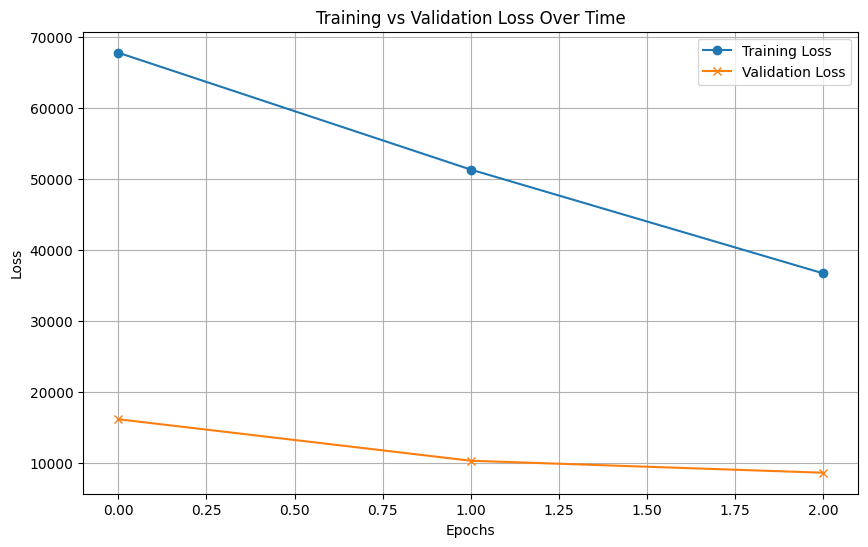

In [10]:
import spacy
from spacy.training.example import Example
from spacy.tokens import DocBin
from pathlib import Path
import random
import matplotlib.pyplot as plt

# Load the transformer-based model
model = spacy.load("en_core_web_trf")

# Load the training data from .spacy file
def load_spacy_data(file_path):
    doc_bin = DocBin().from_disk(file_path)
    return list(doc_bin.get_docs(model.vocab))

# Load training and validation data
train_data = load_spacy_data("./train_split.spacy")
valid_data = load_spacy_data("./validation_split.spacy")

# Function to evaluate the model on validation data
def evaluate_model(model, data):
    examples = [Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in data]
    scorer = model.evaluate(examples)
    return scorer

# Function to calculate validation loss (NLL)
def calculate_validation_loss(nlp, data):
    losses = {}
    for doc in data:
        example = Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]})
        # Compute loss without updating model
        nlp.update([example], sgd=None, losses=losses, drop=0)
    return sum(losses.values())

train_losses = []
val_losses = []

# Disable pipeline components that we don't want to update
pipe_exceptions = ["ner", "transformer"]  # Train NER and transformer components
other_pipes = [pipe for pipe in model.pipe_names if pipe not in pipe_exceptions]
with model.disable_pipes(*other_pipes):  # Only train NER and transformer
    optimizer = model.resume_training()
    optimizer.learn_rate = 0.00005

    # Number of training epochs
    for epoch in range(3):  # Adjust the number of epochs as needed
        losses = {}

        # Shuffle the training data for each epoch
        random.shuffle(train_data)

        # Update the model with the training data
        for doc in train_data:
            example = Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]})
            model.update([example], drop=0.15, losses=losses)

        # Get validation loss after each epoch
        val_loss = calculate_validation_loss(model, valid_data)
      
        train_loss = sum(losses.values())
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1} - Training Loss: {train_loss} | Validation Loss: {val_loss}")
        scorer = evaluate_model(model, valid_data)
        print(f"Validation Score: {scorer}")

# Final evaluation and saving the model
scorer = evaluate_model(model, valid_data)
print(f"Final Validation Score: {scorer}")

# Save the fine-tuned model
model.to_disk("./fine_tuned_ner_model_trf")

# Visualize the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()


WER=Substitutions+Insertions+DeletionsTotal words in the reference\text{WER} = \frac{\text{Substitutions} + \text{Insertions} + \text{Deletions}}{\text{Total words in the reference}}WER=Total words in the referenceSubstitutions+Insertions+Deletions​

Testing the Fine-Tuned Model:

In [29]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


file_path = '../data/Train_1.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['text'])

# Load the SpaCy language model
model = spacy.load('fine_tuned_ner_model_trf')
valid_docs = load_spacy_data("./validation_split.spacy")

def preprocess_tweet(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    #text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional, keeping the hashtag content)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters (optional)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove stopwords and lemmatize (using SpaCy)
    doc = model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_tweet)

# Function to extract locations (GPE) from text
def extract_locations(text):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    
    return ' '.join(set(locations))

# Apply the location extraction to the 'text' column
data['extracted_locations'] = data['cleaned_text'].apply(extract_locations)

# Display the tweets with extracted locations
data[['text', 'extracted_locations']].head()


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\ai4good_location_mention_recognition\.venv\Lib\site-packages\thinc\shims\pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

,text,extracted_locations
1,"Flash floods struck a Maryland city on Sunday,...",
2,State of emergency declared for Maryland flood...,
3,Other parts of Maryland also saw significant d...,
4,"Catastrophic Flooding Slams Ellicott City, Mar...",
5,WATCH: 1 missing after flash #FLOODING devasta...,


In [18]:
valid_data['text']

TypeError: list indices must be integers or slices, not str

In [26]:
predicted_locations

['NZ',
 'Europe',
 'Nebraska',
 'Florida Florida',
 'California',
 'Italy Sri Lankans srilanka',
 'Fort McMurray',
 'Kaikoura',
 'Mexico',
 'Mirpur Kashmir',
 'Brazil',
 'Italy',
 'Mexico',
 'Zimbabwe',
 'Barbuda',
 'Torontos Mexico',
 'Quebradillas PuertoRico',
 'SriLanka',
 'Greece Greece',
 'GREECE Greece',
 'Nebraska',
 'Sri Lanka',
 'MARYLAND Ellicott City Maryland',
 'Haiti',
 'Nebraska',
 'Kozhincherry',
 'Iowa Nebraska',
 'Haiti',
 'Wilmington Florence',
 'Florida',
 'Kerala India Kerala',
 'Puerto Ricoalready',
 'New Zealand',
 'Ecuador Pedernales USA',
 'Haiti Cuba Bahamas',
 'Florida',
 'Mexico Mexico',
 'Wellington',
 'PuertoRico',
 'Kerala',
 'Mexico',
 'Haiti',
 'North Carolina',
 'Mexico',
 'Georgia',
 'Puerto Rico',
 'Nebraska',
 'Ecuador',
 '',
 'Mexicos',
 'Mexico',
 '',
 'Beira Mozambique',
 'Mexico',
 'Mexico',
 'California',
 'Nebraska',
 'haiti',
 'FLORIDA',
 'Sri Lanka',
 'Ecuador',
 'pakistan',
 'Mozambique',
 'Florida',
 'PR',
 'Nebraska',
 'Puerto Rico',
 'Key

In [28]:
from jiwer import wer

# Function to calculate Word Error Rate (WER)
def calculate_wer(row):
    if not row['location'] or not row['extracted_locations']:
        return 1.0  # If either is empty, consider it a complete error
   
    # Use WER function from jiwer package
    return wer(str(row['location']), str(row['extracted_locations']))

# Apply the WER function to compare the 'location' and 'extracted_locations'
data['wer'] = data.apply(calculate_wer, axis=1)

# Display the WER for the first few rows
data[['location', 'extracted_locations', 'wer']].head()

#Get the average WER
average_wer = data['wer'].mean()
print(f"Average Word Error Rate (WER): {average_wer:.4f}")

#Get the accuracy
accuracy = 1 - average_wer  
print(f"Accuracy: {accuracy:.4f}")



Average Word Error Rate (WER): 0.5761
Accuracy: 0.4239


SM:
Average Word Error Rate (WER): 0.5664
Accuracy: 0.4336
LG:
Average Word Error Rate (WER): 0.5471
Accuracy: 0.4529




2.4 Generar submission

In [5]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


file_path = '../data/Test.csv'
data = pd.read_csv(file_path)
#data = data.dropna(subset=['text'])

# Load the SpaCy language model
model = spacy.load('fine_tuned_ner_model_lg')

def preprocess_tweet(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    #text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional, keeping the hashtag content)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters (optional)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove stopwords and lemmatize (using SpaCy)
    doc = model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_tweet)

# Function to extract locations (GPE) from text
def extract_locations(text):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if (ent.label_ == 'GPE')]
    if locations:
        return ' '.join(set(locations))
    else:
        return None

def extract_ner(text):
    doc = model(text)
    entities = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    if entities:
        return entities
    else:
        return None  # Return None if no entities are found

# Apply the location extraction to the 'text' column
data['location'] = data['cleaned_text'].apply(extract_locations)


# Display the tweets with extracted locations
data[['text', 'location']].head()

# Drop the 'text' column from the test data
#data = data.drop(columns=['text'])
data = data.drop(columns=['cleaned_text'])
# Save the test data with extracted locations to a new CSV file
data.to_csv("../data/submission_et.csv", index=False)

#get the  locations  with na or location == ' '
# Get the number of empty entries in the 'location' column

empty_entries = data[data['location'].isna()]
len(empty_entries)


414

In [31]:
empty_entries.to_csv("../data/empty_entries.csv", index=False)

 Creating Location Patterns for the Entity Ruler

In [40]:
import spacy
from spacy.pipeline import EntityRuler

# Load the fine-tuned transformer-based model
nlp = spacy.load("fine_tuned_ner_model_lg")

# Initialize the EntityRuler and define patterns
ruler = nlp.add_pipe("entity_ruler", before="ner")

# Define location patterns (GPE: Geopolitical Entity)
patterns = [
    {"label": "GPE", "pattern": "Greek"},
    {"label": "GPE", "pattern": "greek"},
    {"label": "GPE", "pattern": "Greece"},
    {"label": "GPE", "pattern": "greece"},
    {"label": "GPE", "pattern": "Greeces"},
    {"label": "GPE", "pattern": "puertorico"},
    {"label": "GPE", "pattern": "greeces"},
    {"label": "GPE", "pattern": "KeralaFloods"},
    {"label": "GPE", "pattern": "LA"},
    {"label": "GPE", "pattern": "mozambique"},
    
    
    
    # Add more location patterns as needed
]

# Add patterns to the EntityRuler
ruler.add_patterns(patterns)

# Save the updated pipeline with the EntityRuler added
nlp.to_disk("fine_tuned_ner_model_lg_with_ruler")

In [43]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


file_path = '../data/Test.csv'
data = pd.read_csv(file_path)
#data = data.dropna(subset=['text'])

# Load the SpaCy language model
model = spacy.load('fine_tuned_ner_model_sm_with_ruler')

def preprocess_tweet(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    #text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional, keeping the hashtag content)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters (optional)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove stopwords and lemmatize (using SpaCy)
    doc = model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_tweet)

# Function to extract locations (GPE) from text
def extract_locations(text):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if (ent.label_ == 'GPE')]
    if locations:
        return ' '.join(set(locations))
    else:
        return "None"

def extract_ner(text):
    doc = model(text)
    entities = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    if entities:
        return entities
    else:
        return "None"  # Return None if no entities are found

# Apply the location extraction to the 'text' column
data['location'] = data['cleaned_text'].apply(extract_locations)


# Display the tweets with extracted locations
data[['text', 'location']].head()

# Drop the 'text' column from the test data
data = data.drop(columns=['text'])
data = data.drop(columns=['cleaned_text'])
# Save the test data with extracted locations to a new CSV file
data.to_csv("../data/submission_et.csv", index=False)

#get the  locations  with na or location == ' '
# Get the number of empty entries in the 'location' column

empty_entries = data[data['location'].isna()]
len(empty_entries)


0

In [39]:
empty_entries.to_csv("../data/empty_entries.csv", index=False)